# Trabalho de IA: MLP

Integrantes:
- Ana Clara das Neves Barreto - 13672540
- Eloisa Antero Guisse - 13781924
- Marcos Martins de Oliveira Pacheco - 13672602
- Jamyle Gonçalves Rodrigues Silva - 13672338
- Lucca Pinto - 13781991 
- Sarah Klock Mauricio - 13673131

## Desenvolvimento do modelo

Importações

In [2]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from graphviz import Digraph
import json
import openpyxl

Funções que lidam com a conversão entre letras e vetores de binários

In [3]:
alfabeto = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

def letra_para_vetor(letra):
    """
    Transforma um caractere num vetor de 26 posições, no qual a posição da letra correspondente é 1 e o restante é -1.
    :param letra: Letra a ser transformada num vetor
    :return: Vetor binário de 26 posições
    """
    vetor = [-1] * 26
    pos_letra = alfabeto.index(letra)
    vetor[pos_letra] = 1

    return vetor

def vetor_para_letra(vetor):
    """
    Encontra a letra do alfabeto correspondente a um vetor de 26 posições.
    :param vetor: Vetor de 26 posições que representa uma letra do alfabeto.
    :return: Letra correspondente.
    """
    # Encontra a posição do maior valor no vetor
    maior_pos = np.argmax(vetor)

    # Encontra a letra correspondente no alfabeto
    letra = alfabeto[maior_pos]

    return letra

Funções para leituras de arquivos

In [4]:
def ler_arq_imagens(nome_arq):
    """
    Lê o arquivo de imagens e retorna um array numpy.

    Args:
        nome_arq (str): Caminho para o arquivo de imagens.

    Returns:
        np.ndarray: Array numpy contendo as imagens.
    """
    with open(nome_arq, 'r') as file:
        data = file.read().strip().split('\n')
    data = [list(map(int, filter(lambda x: x.strip(), line.split(',')))) for line in data if line.strip()]
    return np.array(data)

def ler_arq_classes(nome_arq):
    """
    Lê o arquivo de classes e retorna um array numpy.

    Args:
        nome_arq (str): Caminho para o arquivo de classes.

    Returns:
        np.ndarray: Array numpy contendo as classes.
    """
    with open(nome_arq, 'r') as file:
        data = []
        for line in file:
            vetor_letra = letra_para_vetor(line[0])
            data.append(vetor_letra)
    return np.array(data)

Funções para a divisão dos dados

In [5]:
def shuffle_dados(dados, classes):
    """
        Embaralha os dados de um vetor mantendo as respectivas classificações na mesma ordem.

        Args:
            entrada (np.array): Vetor dos dados a serem divididos.
            classes (np.array): Classificação dos dados a serem dividos.

        Returns:
            (np.array): Vetor de dados embaralhado.
            (np.array): Vetor de classificação dos dados da primeira parte da divisão.
        """
    indices = np.arange(dados.shape[0])
    np.random.shuffle(indices)
    return dados[indices], classes[indices]

def dividir_dados(entrada, classes, test_proportion=0.2):
    """
        Divide dois vetores de dados em uma determinada proporção (padrão: 80/20).

        Args:
            entrada (np.array): Vetor dos dados a serem divididos.
            classes (np.array): Classificação dos dados a serem dividos.
            div_proportion (float): Proporção da divisão dos dados (padrão: 20%)

        Returns:
            dados_primeira_parte (np.array): Vetor de dados da primeira parte da divisão.
            classes_primeira_parte (np.array): Vetor de classificação dos dados da primeira parte da divisão.
            dados_segunda_parte (np.array): Vetor de dados da segunda parte da divisão.
            classes_segunda_parte (np.array): Vetor de classificação dos dados da segunda parte da divisão.
        """
    # Transforma os vetores das classes nas letras correspondentes
    classes_letras = []
    for elemento in classes:
        classes_letras.append(vetor_para_letra(elemento))

    classes_letras = np.array(classes_letras)

    # Conta o número de classes
    classes_unicas, num_classes = np.unique(classes_letras, return_counts=True)
    
    # Calcula a quantidade desejada de cada classe no primeiro conjunto
    num_inst_classes = (num_classes * (1 - test_proportion)).astype(int)
    
    # Inicializa os vetores para as duas partes
    dados_primeira_parte = []
    classes_primeira_parte = []
    dados_segunda_parte = []
    classes_segunda_parte = []
    
    for classe, num_inst_classes in zip(classes_unicas, num_inst_classes):
        # Índices das amostras da classe atual
        indices_classe = np.where(classes_letras == classe)[0]

        # Seleciona aleatoriamente as amostras para o primeiro conjunto
        selected_indices = np.random.choice(indices_classe, size=num_inst_classes, replace=False)
        
        # Divide os dados e classes
        dados_primeira_parte.append(entrada[selected_indices])
        classes_primeira_parte.append(classes[selected_indices])
        
        # As amostras restantes vão para o segundo conjunto
        remaining_indices = np.setdiff1d(indices_classe, selected_indices)
        dados_segunda_parte.append(entrada[remaining_indices])
        classes_segunda_parte.append(classes[remaining_indices])
    
    # Concatena os vetores
    dados_primeira_parte = np.concatenate(dados_primeira_parte)
    classes_primeira_parte = np.concatenate(classes_primeira_parte)
    dados_segunda_parte = np.concatenate(dados_segunda_parte)
    classes_segunda_parte = np.concatenate(classes_segunda_parte)

    dados_primeira_parte, classes_primeira_parte = shuffle_dados(dados_primeira_parte, classes_primeira_parte)
    dados_segunda_parte, classes_segunda_parte = shuffle_dados(dados_segunda_parte, classes_segunda_parte)

    return dados_primeira_parte, classes_primeira_parte, dados_segunda_parte, classes_segunda_parte


Funcao pra reconstruir imagens a partir do array de array


In [34]:
def reconstruct_image(row_index, image_array):
    """
    Reconstrói e plota uma imagem a partir do array numpy.

    Args:
        row_index (int): Índice da linha da imagem a ser reconstruída.
        image_array (np.ndarray): Array numpy contendo as imagens.
    """
    image_array = image_array[row_index]
    image_reshaped = np.reshape(image_array, (10, 12))

    plt.figure(figsize=(4, 3))
    plt.imshow(image_reshaped, cmap='gray')
    plt.colorbar()
    plt.show()

In [ ]:
image = ler_arq_imagens('X.txt')
reconstruct_image(5,image)

Função para matriz de confusão

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plotar_matriz_de_confusao(predictions, y_test):
    """
    Traduz os dados dos arrays predictions e y_test para outros dois arrays
    apenas contendo as letras previstas e originais de teste e plota uma matriz
    de confusão usando o sklearn.metrics

    Args:
        predictions: Array contendo os resultados previstos pelo MLP.
        y_test: Array contendo os dados de teste do MLP
    """
    
    # Listas que irão conter as letras previstas e de teste
    predictions_letras = []
    y_test_letras = []

    # Converter os arrays de predictions e y_test para letras
    i = 0
    for i in range(len(predictions)):
        letra = vetor_para_letra(predictions[i])
        predictions_letras.append(letra)
    
    j = 0
    for j in range(len(predictions)):    
       letra = vetor_para_letra(y_test[j])
       y_test_letras.append(letra)

    # Array com todas as possibilidades, ou seja, o alfabeto de 'A' a 'Z'
    classes = [chr(i) for i in range(65, 91)] 
        
    cm = confusion_matrix(y_test_letras, predictions_letras, labels= classes)

    # Plot usando ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix using ConfusionMatrixDisplay')
    plt.show()


Funções de ativação

In [6]:
def sigmoid(x, der=False):
    if der:
        fx = sigmoid(x)
        return fx * (1 - fx)
    return 1.0 / (1.0 + np.exp(-x))

def tanh(x, der=False):
    if der:
        return 1 - np.tanh(x) ** 2
    return np.tanh(x)

def relu(x, der=False):
    if der:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def leaky_relu(x, der=False):
    alpha = 0.01
    if der:
        return np.where(x > 0, 1, alpha)
    return np.where(x > 0, x, alpha * x)

def soft_max(x, der=False):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

def activation_function(x, func, der=False):
    return func(x, der)

activation_functions1_names = ["sigmoid", "tanh", "relu", "leaky_relu"]
activation_functions2_names = ["tanh", "leaky_relu"]
activation_functions = {"sigmoid": sigmoid, 
                        "tanh": tanh, 
                        "relu": relu, 
                        "leaky_relu": leaky_relu
                        }

Função para inicialização de pesos

In [7]:
def init_xavier(n_in, n_out):
    """
    Inicializa os pesos com a inicialização Xavier.

    Args:
        n_in (int): Número de unidades na camada de entrada (ou unidades na camada anterior).
        n_out (int): Número de unidades na camada de saída.

    Returns:
        (numpy.ndarray): Uma matriz de pesos inicializados.
    """
    stddev = np.sqrt(2.0 / (n_in + n_out))
    return np.random.randn(n_in, n_out) * stddev

Classes da MLP (e início efetivo da codificação da rede neural)

In [8]:
class Layer:
    def __init__(self, input_size, output_size, learning_rate, act_fun, output_layer=False, momentum=0):
        """
        Inicializa uma nova camada na rede neural.

        Args:
            input_size (int): Número de neurônios na camada anterior ou tamanho dos dados de entrada.
            output_size (int): Número de neurônios na camada atual.
            learning_rate (float): Taxa de aprendizado usada para ajustar os pesos e biases durante o treinamento.
            act_fun (function): Função de ativação da camada.
            output_layer (bool): Booleano que indica se a camada é a de saída da MLP ou não.

        Attributes:
            weights (np.array): Matriz de pesos, onde cada peso conecta um neurônio de entrada a um neurônio de saída.
            biases (np.array): Vetor de biases, um para cada neurônio de saída.
            weighted_input (np.array): Armazena a entrada ponderada (antes da aplicação de qualquer função de ativação).
            output_data (np.array): Armazena a saída da camada, que neste caso é simplesmente a entrada ponderada.
            input_data (np.array): Armazena a entrada da camada antes da ponderação.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.act_fun = act_fun
        self.output_layer = output_layer
        self.momentum = momentum
        self.weights = init_xavier(input_size, output_size) 
        self.biases = np.random.randn(1, output_size)
        self.previous_weight_delta = np.zeros((input_size, output_size))
        self.weighted_input = None
        self.output_data = None
        self.input_data = None

    def forward(self, input_data):
        """
        Realiza o feed forward da camada.

        :param input_data: Vetor de dados de entrada.
        :return: Saída após multiplicação pelos pesos e função de ativação.
        """
        self.input_data = input_data
        self.weighted_input = np.dot(input_data, self.weights) + self.biases
        self.output_data = activation_function(self.weighted_input, self.act_fun)

        return self.output_data

    def backward(self, error):
        """
        Realiza o backward propagation da camada.

        :param error: Erros que serão usados para calcular a correção dos pesos.
        :return: Gradientes para serem usados na correção da camada abaixo.
        """
        # Caso não seja a camada de saída, multiplica o erro pela derivada da função de ativação sobre a entrada ponderada da camada.
        if not self.output_layer:
            error = error * activation_function(self.weighted_input, self.act_fun, True)

        if self.input_data.ndim == 1:
            self.input_data = self.input_data.reshape(1, -1)  # Garante que input_data é bidimensional
        if error.ndim == 1:
            error = error.reshape(1, -1)  # Garante que error é bidimensional

        # Calcula correções e gradientes
        input_error = np.dot(error, self.weights.T)
        weights_error = np.dot(self.input_data.T, error) * self.learning_rate + self.momentum * self.previous_weight_delta
        self.previous_weight_delta = weights_error

        # Atualiza pesos e biases
        self.weights += weights_error
        self.biases += self.learning_rate * np.sum(error, axis=0, keepdims=True)
        return input_error

In [9]:
class NeuralNetwork:
    def __init__(self, learning_rate, neurons_n=120, activation_func1=sigmoid, activation_func2=leaky_relu):
        """
        Inicializa a rede neural com camadas especificadas.

        Args:
            learning_rate (float): Taxa de aprendizado usada para ajustar os pesos e biases durante o treinamento.

        Attributes:
            learning_rate (float): Taxa de aprendizado da rede neural.
            hidden_layer1 (Layer): Primeira camada oculta da rede neural.
            output_layer (Layer): Camada de saída da rede neural.
            final_output (np.array): Armazena a saída final da rede após a propagação direta.
        """
        self.learning_rate = learning_rate
        self.hidden_layer1 = Layer(120, neurons_n, self.learning_rate, activation_func1, momentum=0.8)
        self.output_layer = Layer(neurons_n, 26, self.learning_rate, activation_func2, True, momentum=0.8)
        self.final_output = None

    def forward_propagation(self, input_data):
        """
        Realiza a propagação para frente através de toda a rede.

        Args:
            input_data (np.array): Dados de entrada para a rede.

        Returns:
            np.array: Saída final da rede.
        """
        output = self.hidden_layer1.forward(input_data)
        self.final_output = self.output_layer.forward(output)
        return self.final_output

    def back_propagation(self, output_error):
        """
        Realiza a propagação para trás através de toda a rede.

        Args:
            output_error (np.array): Erro na saída da rede.
        """
        error = self.output_layer.backward(output_error)
        self.hidden_layer1.backward(error)

In [59]:
class MultilayerPerceptron:
    def __init__(self, early_stop_param=30, learning_rate=0.0005, min_training_error=0.00000000001, max_epochs_num=500, neurons_n=50, activation_func1=sigmoid, activation_func2=tanh, print_mlp=True):
        """
        Inicializa os parâmetros para o treinamento da rede neural.

        Args:
            learning_rate (float): Taxa de aprendizado do modelo.
            early_stop_param (int): Número de épocas sem diminuição de erro permitido pelo earlystop.
            min_training_error_error (float): Erro mínimo desejado para o treinamento.
            max_epochs_num (int): Número máximo de épocas para o treinamento.

        Attributes:
            learning_rate (float): Taxa de aprendizado do modelo.
            early_stop_param (int): Número de épocas sem diminuição de erro permitido pelo earlystop.
            min_training_error_error (float): Erro mínimo desejado para o treinamento.
            max_epochs_num (int): Número máximo de épocas para o treinamento.
            min_error (float): Menor erro de validação encontrado.
            negative_error_var_num (int): Contador de épocas com aumento do erro.
            neural_network (NeuralNetwork): Rede neural do modelo.
        """
        self.learning_rate = learning_rate
        self.early_stop_param = early_stop_param
        self.min_training_error = min_training_error
        self.max_epochs_num = max_epochs_num
        self.min_error = 1
        self.negative_error_var_num = 0
        self.print_mlp = print_mlp

        # Lista para armazenar os erros de treinamento em cada época
        self.training_errors = []

        # Lista para armazenar os erros de validação em cada época (em caso de earlystop)
        self.validation_errors = []

        # Inicializa a rede neural
        self.neural_network = NeuralNetwork(learning_rate=learning_rate, neurons_n=neurons_n, activation_func1=activation_func1, activation_func2=activation_func2)
        
    def train(self, entrada, classes, earlystop=False):
        """
        Treina a rede neural usando o conjunto de dados de treinamento.

        Args:
            entrada (np.array): Dados de entrada para treinamento.
            classes (np.array): Labels correspondentes para o treinamento.
            earlystop (boolean): Booleano que indica se earlystop será usado ou não
        """

        # Divide os dados de entrada num conjunto de treinamento e outro de validação
        x_train, y_train, x_val, y_val = dividir_dados(entrada, classes)

        # Cria uma variável que irá armazenar a rede neural com o menor erro encontrado
        best_neural_network = copy.deepcopy(self.neural_network)
        
        # Treina a MLP
        for epoch in range(self.max_epochs_num):
            epoch_error = 0
            # Embaralha a entrada
            x_train, y_train = shuffle_dados(x_train, y_train)
            
            # Loop que treina a MLP com os dados de treinamento
            for x, y in zip(x_train, y_train):
                # Realiza o feed forward
                output = self.neural_network.forward_propagation(x)

                # Calcula o erro de saída
                output_error = y - output

                # Realiza o back propagation
                self.neural_network.back_propagation(output_error)

                # Calcula o erro quadrático médio e soma ao erro médio da época
                epoch_error += np.mean((np.power(output_error, 2))/2)

            # Armazena erro de treinamento médio
            train_error = epoch_error / x_train.shape[0]

            # Calcula a acurácia e erro de validação do modelo
            acuracia, val_error, dp_erro = self.get_accuracy(x_val, y_val)
            
            # Armazena os erros nos vetores de erros
            self.training_errors.append(train_error)
            self.validation_errors.append(val_error)

            # Printa erro e acurácia a cada dez épocas
            if self.print_mlp and epoch % 10 == 0:
                print(
                    f"Época {epoch}/{self.max_epochs_num}, Acurácia: {acuracia:.5f}, Erro de validação: {val_error:.5f}, Erro de treino: {train_error:.5f}")
            
            # Verifica se foi atingido um erro mínimo de treinamento
            if train_error < self.min_training_error:
                    print("Erro mínimo atingido. Parando o treinamento.")
                    break
            
            if earlystop: 
                
                # Verifica se foi encontrado um erro de validação menor que o mínimo registrado
                if val_error <= self.min_error:

                    # Atualiza menor erro encontrado
                    self.min_error = val_error

                    # Zera o contador de aumento de erro
                    self.negative_error_var_num = 0

                    # Salva a rede neural que obteve o menor erro
                    best_neural_network = copy.deepcopy(self.neural_network)

                # Se não, aumenta o contador de épocas sem diminuição do erro
                else:
                    self.negative_error_var_num += 1

                if self.negative_error_var_num >= self.early_stop_param:
                    print("Parando antecipadamente devido à estabilização do erro de validação.")
                    # Restaura o melhor conjunto de pesos encontrado
                    self.neural_network = copy.deepcopy(best_neural_network)
                    break
        
    def get_accuracy(self, entrada, saida_esperada):
        """
        Obtém a acurácia e erro médio da MLP.

        Args:
            entrada (np.array): Dados de entrada para teste.
            saida_esperada (np.array): Saída esperada da rede neural.

        Returns:
            acuracia (float): Porcentagem de acertos da rede.
            erro_medio (float): Erro médio.
            erro_dp (float): Desvio padrão do erro.
        """

        # Inicializa variáveis para calcular acurácia
        num_testes = 0
        num_acertos = 0
        erros = []

        # Realiza teste para cada um dos dados de entrada
        for x, y in zip(entrada, saida_esperada):
            num_testes += 1
            
            # Realiza a predição
            predicao = self.neural_network.forward_propagation(x)

            # Calcula erro
            output_error = y - predicao
            erros.append(np.mean((np.power(output_error, 2) / 2)))

            # Obtém a letra predita pelo modelo
            letra_predita = vetor_para_letra(predicao)

            # Obtém a letra esperada
            letra_real = vetor_para_letra(y)

            if letra_predita == letra_real:
                num_acertos += 1

        
        acuracia = num_acertos / num_testes
        erro_medio = np.mean(erros)
        erro_dp = np.std(erros)

        return acuracia, erro_medio, erro_dp

    def predict(self, entrada):
        """
        Realiza predições usando a rede neural treinada.

        Args:
            entrada (np.array): Dados de entrada para teste.
            neural_network (NeuralNetwork): Instância da rede neural treinada.

        Returns:
            np.array: Predições da rede neural.
        """
        predictions = []
        for x in entrada:
            output = self.neural_network.forward_propagation(x)
            predictions.append(output)
        return np.array(predictions)
    
    def save_mlp(self, nome_arq, x_test, y_test):
        """
        Armazena os pesos das camadas e os erros médios de cada época num arquivo.

        Args:
            nome_arq (string): Nome do arquivo que irá armazenar os valores.
        """ 

        network = { 
            # Conversão dos pesos da primeira camada oculta para uma lista
            'hidden_layer1': {'weights': self.neural_network.hidden_layer1.weights.tolist(),
                            'biases': self.neural_network.hidden_layer1.biases.tolist()},

            # Conversão dos pesos da camada de saída para uma lista
            'output_layer': {'weights': self.neural_network.output_layer.weights.tolist(),
                            'biases': self.neural_network.output_layer.biases.tolist()},
            
            'train_errors' : self.training_errors,
            'val_errors' : self.validation_errors,
            'x_test': x_test.tolist(),
            'y_test': y_test.tolist()
        }

        # Abertura do arquivo para escrita
        with open(nome_arq, 'w') as f:
            # Salvando o dicionário no formato JSON
            json.dump(network, f) 

    def build_mlp(self, nome_arq):
        """
        Constrói a MLP a partir de um arquivo de pesos.

        Args:
            nome_arq (string): Nome do arquivo com os pesos e biases de cada camada.
        """
        with open(nome_arq, 'r') as f:
            network = json.load(f)

        self.neural_network.hidden_layer1.weights = np.array(network['hidden_layer1']['weights'])
        self.neural_network.hidden_layer1.biases = np.array(network['hidden_layer1']['biases'])
        self.neural_network.output_layer.weights = np.array(network['output_layer']['weights'])
        self.neural_network.output_layer.biases = np.array(network['output_layer']['biases'])

        self.training_errors = network['train_errors']
        self.validation_errors = network['val_errors']

        return np.array(network['x_test']), np.array(network['y_test'])

Main: treina o modelo, printa a execução de cada época e depois obtém a acurácia e erro médio final.

In [87]:
def main():
    # Lendo os arquivos
    imagens = ler_arq_imagens('X.txt')
    classes = ler_arq_classes('Y_letra.txt')

    # Dividindo os dados em conjuntos de treinamento e teste
    x_train, y_train, x_test, y_test = dividir_dados(imagens, classes, test_proportion=0.2)

    # Convertendo para float
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)

    # Parâmetros para o treinamento
    early_stop_param = 10
    learning_rate = 0.005
    min_output_error = 0.000000001
    max_epochs_num = 500

    # Inicializa o Multilayer Perceptron com os parâmetros de treinamento
    mlp = MultilayerPerceptron(early_stop_param, learning_rate, min_output_error, max_epochs_num, 50, sigmoid, tanh, True)

    # Treina a rede neural
    mlp.train(x_train, y_train, True)

    print("Treinamento concluído.")

    acuracia, erro, dp = mlp.get_accuracy(x_test, y_test)
    print(f"Acurácia do modelo: {acuracia}")
    print(f"Erro médio do modelo: {erro}")
    print(f"Desvio padrão do erro: {dp}")

    # Testa a rede neural
    predictions = mlp.predict(x_test)

    # Exibe algumas predições para verificação
    for i in range(20):
        predicao = vetor_para_letra(predictions[i])
        correto = vetor_para_letra(y_test[i])

        print(f"Predição: {predicao}, Real: {correto}")

    # Armazena MLP num arquivo
    mlp.save_mlp("mlp.txt", x_test, y_test)

    # Plota a matriz de confusão
    plotar_matriz_de_confusao(predictions, y_test)

main()

Época 0/500, Acurácia: 0.61538, Erro de validação: 0.04387, Erro de treino: 0.06632
Época 10/500, Acurácia: 0.90865, Erro de validação: 0.01282, Erro de treino: 0.00342
Época 20/500, Acurácia: 0.90865, Erro de validação: 0.01126, Erro de treino: 0.00064
Parando antecipadamente devido à estabilização do erro de validação.
Treinamento concluído.
Acurácia do modelo: 0.8846153846153846
Erro médio do modelo: 0.014011230890232863
Desvio padrão do erro: 0.027612349348072288
Predição: B, Real: R
Predição: I, Real: L
Predição: L, Real: L
Predição: C, Real: C
Predição: L, Real: L
Predição: O, Real: O
Predição: D, Real: D
Predição: I, Real: I
Predição: Z, Real: Z
Predição: I, Real: Z
Predição: O, Real: O
Predição: A, Real: A
Predição: A, Real: A
Predição: C, Real: C
Predição: R, Real: R
Predição: V, Real: V
Predição: O, Real: O
Predição: I, Real: I
Predição: J, Real: J
Predição: V, Real: V


NameError: name 'plotar_matriz_de_confusao' is not defined

In [ ]:
def grid_search():
    # Lendo os arquivos
    imagens = ler_arq_imagens('X.txt')
    classes = ler_arq_classes('Y_letra.txt')

    early_stop = [10, 30, 50]
    for es in early_stop:

        # Dividindo os dados em conjuntos de treinamento e teste
        x_train, y_train, x_test, y_test = dividir_dados(imagens, classes, test_proportion=tp)

        # Convertendo para float
        y_train = y_train.astype(float)
        y_test = y_test.astype(float)

        # Parâmetros fixos para o treinamento
        early_stop_param = es
        min_output_error = 0.000000001
        max_epochs_num = 500

        grid_results = {
            "Taxa de aprendizado": [],
            "Nº de neuronios camada escondida": [],
            "Função de ativação 1": [],
            "Função de ativação 2": [],
            "Acurácia": [],
            "Erro médio": [],
            "Desvio padrão de erro": [],
            "Erros de treinamento por época": [],
            "Erros de validação por época": [],
            "Proporção conjunto de testes": []
        }
        
        learning_rate = 0.0005
        neurons_n = 50
        af1 = "sigmoid"
        af2 = "tanh"
        
        parameters = f"{learning_rate}, {neurons_n}, {af1}, {af2}"
        print(f"Busca por parametros:", parameters)

        activation_func1 = activation_functions[af1]
        activation_func2 = activation_functions[af2]

        # Inicializa o Multilayer Perceptron com os parâmetros de treinamento
        mlp = MultilayerPerceptron(early_stop_param, learning_rate, min_output_error, max_epochs_num, neurons_n, activation_func1, activation_func2, print_mlp=True)

        # Treina a rede neural
        mlp.train(x_train, y_train, True)

        print("Treinamento concluído.")

        acuracia, erro, dp = mlp.get_accuracy(x_test, y_test)
        print(f"Acurácia, erro médio e desvio padrão do erro: {acuracia}, {erro}, {dp}")
        
        grid_results["Taxa de aprendizado"].append(learning_rate)
        grid_results["Nº de neuronios camada escondida"].append(neurons_n)
        grid_results["Função de ativação 1"].append(af1)
        grid_results["Função de ativação 2"].append(af2)
        grid_results["Acurácia"].append(acuracia)
        grid_results["Erro médio"].append(erro)
        grid_results["Desvio padrão de erro"].append(dp)
        grid_results["Erros de treinamento por época"].append(mlp.training_errors)
        grid_results["Erros de validação por época"].append(mlp.validation_errors)
        grid_results["Proporção conjunto de testes"].append(tp)

        tp += 0.1
    
    return grid_results

grid_search_results = grid_search()
pd.DataFrame(grid_search_results).to_csv('grid_search_results.csv', index=False)

Teste e exemplo da função de reconstruir MLP a partir do arquivo de pesos.

In [ ]:
def teste_build_mlp():
    # Lendo os arquivos
    imagens = ler_arq_imagens('X.txt')
    classes = ler_arq_classes('Y_letra.txt')

    # Inicializa MLP sem nenhum parâmetro 
    mlp = MultilayerPerceptron()

    # Chama a função para construir os pesos a partir do arquivo
    x_test, y_test = mlp.build_mlp('mlp.txt')

    # Testa a rede neural
    predictions = mlp.predict(x_test)

    acuracia, erro, dp = mlp.get_accuracy(x_test, y_test)
    print(f"Acurácia do modelo: {acuracia}")
    print(f"Erro médio do modelo: {erro}")
    print(f"Desvio padrão do modelo: {dp}")

    plotar_matriz_de_confusao(predictions, y_test)

teste_build_mlp()

Testes early stop

In [ ]:
def grid_search():
    # Lendo os arquivos
    imagens = ler_arq_imagens('X.txt')
    classes = ler_arq_classes('Y_letra.txt')

    early_stop = [500, 100, 50, 30, 10]
    testes = []
    for es in early_stop:
        acc = []
        err = []
        for i in range(0, 5):
            # Dividindo os dados em conjuntos de treinamento e teste
            x_train, y_train, x_test, y_test = dividir_dados(imagens, classes, test_proportion=0.2)

            # Convertendo para float
            y_train = y_train.astype(float)
            y_test = y_test.astype(float)

            # Parâmetros fixos para o treinamento
            early_stop_param = es
            min_output_error = 0.000000001
            max_epochs_num = 500
            
            learning_rate = 0.0005
            neurons_n = 50
            af1 = "sigmoid"
            af2 = "tanh"
            
            parameters = f"{learning_rate}, {neurons_n}, {af1}, {af2}"
            print(f"Busca por parametros:", parameters)

            activation_func1 = activation_functions[af1]
            activation_func2 = activation_functions[af2]

            # Inicializa o Multilayer Perceptron com os parâmetros de treinamento
            mlp = MultilayerPerceptron(early_stop_param, learning_rate, min_output_error, max_epochs_num, neurons_n, activation_func1, activation_func2, print_mlp=True)

            # Treina a rede neural
            mlp.train(x_train, y_train, True)

            print("Treinamento concluído.")

            acuracia, erro, dp = mlp.get_accuracy(x_test, y_test)
            print(f"Acurácia, erro médio e desvio padrão do erro: {acuracia}, {erro}, {dp}")

            acc.append(acuracia)
            err.append(erro)
        
        acc_med = np.mean(acc)
        err_med = np.mean(err)
        err_dp = np.std(err)

        testes.append([acc_med, err_med, err_dp])
    
    return testes
        
modelos = grid_search()

In [85]:
# Plot training and validation errors for the two specified models in a single row
com_dois = pd.read_csv("csvs/com_dois.csv")

# Plot training and validation errors side by side for the specified models
fig, axes = plt.subplots(1, 2, figsize=(14, 7))


# Plot for the model with both momentum and Xavier initialization
axes[1].plot(com_dois.loc[0, 'Erros de treinamento por época'], label='Erro de Treinamento')
axes[1].plot(com_dois.loc[0, 'Erros de validação por época'], label='Erro de Validação')
axes[1].set_title('Com Momentum e Com Xavier - Erros por Época')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Erro')
#axes[1].set_ylim([all_min_error, all_max_error])
#axes[1].set_yticks(all_y_ticks)
axes[1].legend()
axes[1].grid(True)  # Enable grid

plt.tight_layout()
plt.show()

C:\Users\despinxz\AppData\Local\Temp\ipykernel_19936\1250346326.py:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


ValueError: Image size of 94549x629 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1400x700 with 2 Axes>

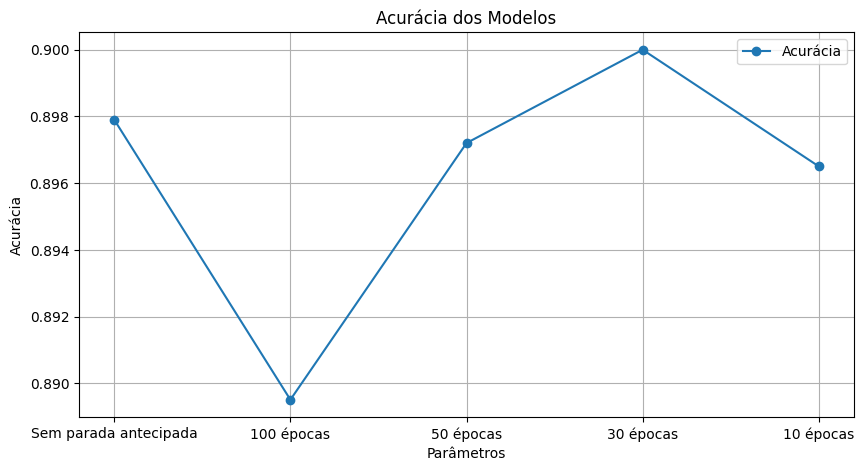

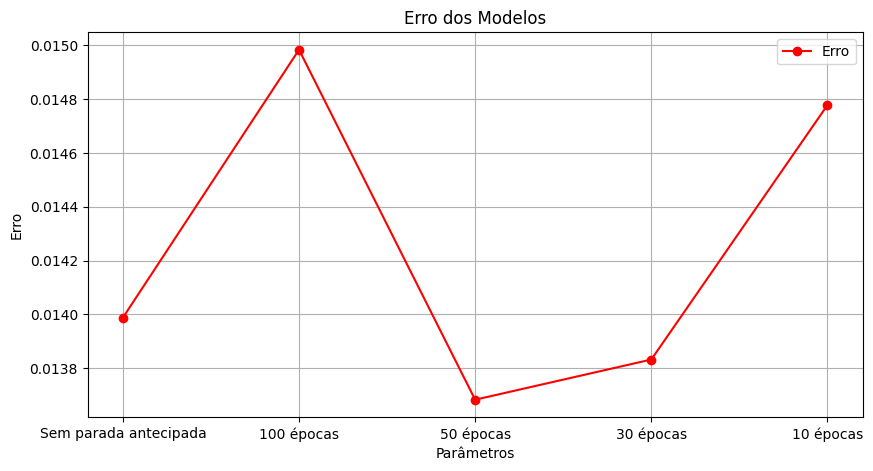

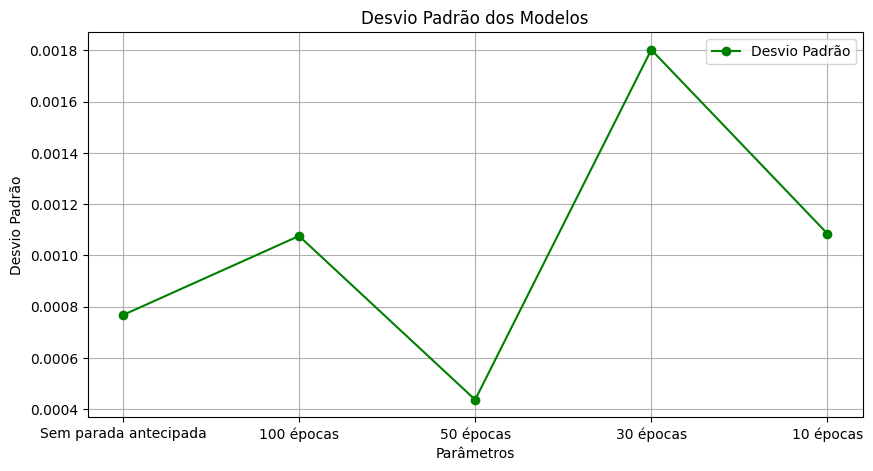

In [77]:
parametros = ["Sem parada antecipada", "100 épocas", "50 épocas", "30 épocas", "10 épocas"]
dados = modelos

# Extrair acurácia, erro e desvio padrão
acuracias = [d[0] for d in modelos]
erros = [d[1] for d in modelos]
desvios = [d[2] for d in modelos]

# Plotando as acurácias
plt.figure(figsize=(10, 5))
plt.plot(parametros, acuracias, marker='o', label='Acurácia')
plt.xlabel('Parâmetros')
plt.ylabel('Acurácia')
plt.title('Acurácia dos Modelos')
plt.legend()
plt.grid(True)
plt.show()

# Plotando os erros
plt.figure(figsize=(10, 5))
plt.plot(parametros, erros, marker='o', label='Erro', color='red')
plt.xlabel('Parâmetros')
plt.ylabel('Erro')
plt.title('Erro dos Modelos')
plt.legend()
plt.grid(True)
plt.show()

# Plotando os desvios padrões
plt.figure(figsize=(10, 5))
plt.plot(parametros, desvios, marker='o', label='Desvio Padrão', color='green')
plt.xlabel('Parâmetros')
plt.ylabel('Desvio Padrão')
plt.title('Desvio Padrão dos Modelos')
plt.legend()
plt.grid(True)
plt.show()

Cross-validation

In [12]:
def kfold(entrada, classes, num_particoes):
    """
    Divide os dados e classes em K partições para K-Fold Cross-Validation.

    Args:
        entrada (np.array): Vetor dos dados a serem divididos.
        classes (np.array): Vetor das classes dos dados.
        num_particoes (int): Número de partições (K).

    Returns:
        dados_particionados (list): Lista de K partições dos dados.
        classes_particionadas (list): Lista de K partições das classes.
    """
    # Transforma os vetores das classes nas letras correspondentes
    classes_letras = []
    for elemento in classes:
        classes_letras.append(vetor_para_letra(elemento))

    classes_letras = np.array(classes_letras)

    # Conta o número de classes e a quantidade de instâncias de cada uma delas no vetor de dados
    classes_unicas, num_classes = np.unique(classes_letras, return_counts=True)
    
    # Calcula a quantidade desejada de cada classe nos conjuntos
    num_inst_classes = (num_classes / num_particoes).astype(int)
    
    # Cria a lista de partições
    particoes = [[] for _ in range(num_particoes)]
    
    for classe, num_inst_classe in zip(classes_unicas, num_inst_classes):
        # Índices das amostras da classe atual
        indices = np.where(classes_letras == classe)[0]

        # Embaralha os índices
        np.random.shuffle(indices)

        # Adiciona o número de instâncias certo da classe em cada partição
        for i in range(num_particoes):
            if i != num_particoes - 1:
                particoes[i].extend(indices[(i * num_inst_classe) : ((i + 1) * num_inst_classe)])
            else:
                particoes[i].extend(indices[(i * num_inst_classe) :])
    
    dados_particionados = []
    classes_particionadas = []

    # Define os vetores de dados e classificação de cada partição
    for p in particoes:
        dados_particionados.append(entrada[p])
        classes_particionadas.append(classes[p])

    # Embaralha os dados de cada partição
    for i in range(num_particoes):
        dados_particionados[i], classes_particionadas[i] = shuffle_dados(dados_particionados[i], classes_particionadas[i])

    return dados_particionados, classes_particionadas

In [41]:
def train_cross_validation(entrada, classes, num_particoes):
    """
    Realiza o treinamento com cross validation de uma MLP.

    Args:
        entrada (np.array): Vetor dos dados de entrada.
        classes (np.array): Vetor das classes dos dados.
        num_particoes (int): Número de partições (K).
    """
    num_particoes = 15
    particoes_dados, particoes_classes = kfold(entrada, classes, num_particoes)

    early_stop_param = 30
    learning_rate = 0.0005
    min_output_error = 0.0000000001
    max_epochs_num = 500

    acuracias = []
    erros = []
    mlps = []

    for i in range(num_particoes):
        print(f"Treinamento K-Fold {i + 1}: ")

        # Define conjunto de testes
        dados_teste = particoes_dados[i]
        classes_teste = particoes_classes[i]

        # Remove conjunto de testes das partições
        min_output_error, max_epochs_num, early_stop_param, learning_rate
        dados_treinamento = [particao for j, particao in enumerate(particoes_dados) if j != i]
        dados_treinamento = np.concatenate(dados_treinamento)
        classes_treinamento = [particao for j, particao in enumerate(particoes_classes) if j != i]
        classes_treinamento = np.concatenate(classes_treinamento)

        # Inicializa o Multilayer Perceptron com os parâmetros de treinamento
        mlp = MultilayerPerceptron(early_stop_param, learning_rate, min_output_error, max_epochs_num)

        # Treina MLP
        mlp.train(dados_treinamento, classes_treinamento, earlystop=True)

        mlps.append(mlp)

        print(f"Treinamento {i + 1} finalizado.")
        acuracia, erro_medio, dp = mlp.get_accuracy(dados_teste, classes_teste)
        print(f"Acurácia: {acuracia:.2f}")
        print(f"Erro médio: {erro_medio:.2f}")
        print(f"Desvio padrão do erro: {dp:.2f}\n")

        acuracias.append(acuracia)
        erros.append(erro_medio)
    
    print("Cross-validation concluído.")
    print(f"Acurácia média: {np.mean(acuracias):.2f}")
    print(f"Desvio padrão da acurácia: {np.std(acuracias):.3f}")
    print(f"Erro médio: {np.mean(erros):.5f}")
    print(f"Desvio padrão: {np.std(erros):.5f}")

    return mlps, acuracias, erros

# Lendo os arquivos
imagens = ler_arq_imagens('X.txt')
classes = ler_arq_classes('Y_letra.txt')

# Dividindo os dados em conjuntos de treinamento e teste
x_train, y_train, x_test, y_test = dividir_dados(imagens, classes, test_proportion=0.2)

# Convertendo para float
classes = classes.astype(float)

mlps, acuracias, erros = train_cross_validation(x_train, y_train, 7)

Treinamento K-Fold 1: 
Época 0/500, Acurácia: 0.13462, Erro de validação: 0.07264, Erro de treino: 0.08671
Época 10/500, Acurácia: 0.78365, Erro de validação: 0.03815, Erro de treino: 0.03600
Época 20/500, Acurácia: 0.82692, Erro de validação: 0.02727, Erro de treino: 0.02112
Época 30/500, Acurácia: 0.84615, Erro de validação: 0.02281, Erro de treino: 0.01437
Época 40/500, Acurácia: 0.85577, Erro de validação: 0.02027, Erro de treino: 0.01036
Época 50/500, Acurácia: 0.86538, Erro de validação: 0.01873, Erro de treino: 0.00786
Época 60/500, Acurácia: 0.87019, Erro de validação: 0.01763, Erro de treino: 0.00608
Época 70/500, Acurácia: 0.88462, Erro de validação: 0.01696, Erro de treino: 0.00476
Época 80/500, Acurácia: 0.87981, Erro de validação: 0.01667, Erro de treino: 0.00386
Época 90/500, Acurácia: 0.89423, Erro de validação: 0.01605, Erro de treino: 0.00316
Época 100/500, Acurácia: 0.88942, Erro de validação: 0.01597, Erro de treino: 0.00263
Época 110/500, Acurácia: 0.89423, Erro de 

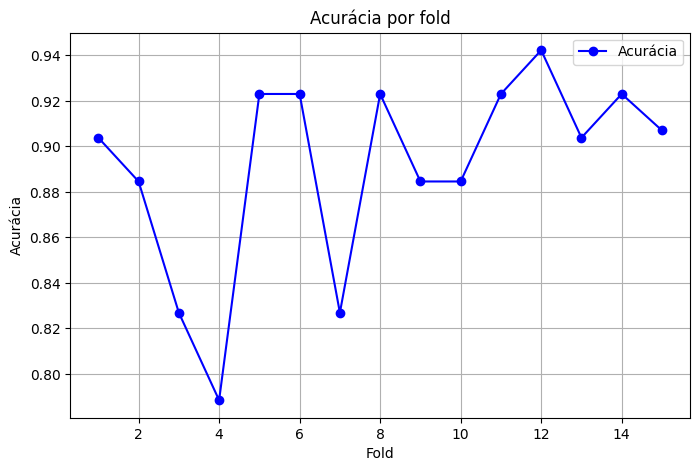

In [42]:
# Índices do vetor (0 a 6)
indices = list(range(1, len(acuracias) + 1))

# Criar o gráfico
plt.figure(figsize=(8, 5))
plt.plot(indices, acuracias, marker='o', linestyle='-', color='b', label='Acurácia')

# Adicionar títulos e legendas
plt.title('Acurácia por fold')
plt.xlabel('Fold')
plt.ylabel('Acurácia')
plt.legend()

# Mostrar o gráfico
plt.grid(True)
plt.show()

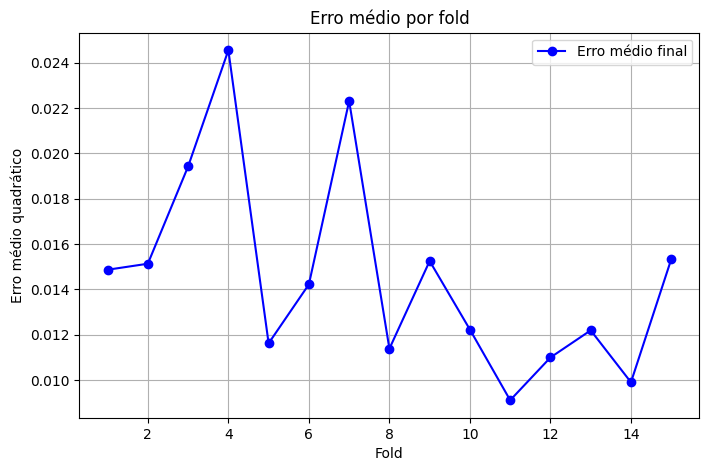

In [43]:
# Índices do vetor (0 a 6)
indices = list(range(1, len(acuracias) + 1))

# Criar o gráfico
plt.figure(figsize=(8, 5))
plt.plot(indices, erros, marker='o', linestyle='-', color='b', label='Erro médio final')

# Adicionar títulos e legendas
plt.title('Erro médio por fold')
plt.xlabel('Fold')
plt.ylabel('Erro médio quadrático')
plt.legend()

# Mostrar o gráfico
plt.grid(True)
plt.show()

In [45]:
acuracias_teste = []
erros_teste = []
dp_teste = []

for mlp in mlps:
    acc, err, dp = mlp.get_accuracy(x_test, y_test)
    acuracias_teste.append(acc)
    erros_teste.append(err)
    dp_teste.append(dp)

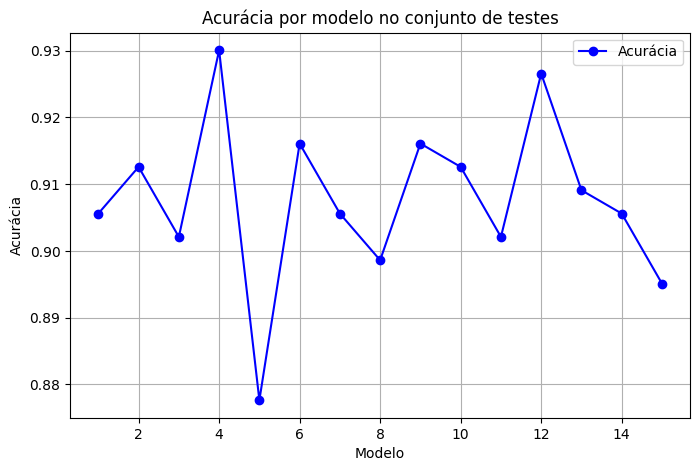

In [46]:
# Índices do vetor (0 a 6)
indices = list(range(1, len(acuracias_teste) + 1))

# Criar o gráfico
plt.figure(figsize=(8, 5))
plt.plot(indices, acuracias_teste, marker='o', linestyle='-', color='b', label='Acurácia')

# Adicionar títulos e legendas
plt.title('Acurácia por modelo no conjunto de testes')
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.legend()

# Mostrar o gráfico
plt.grid(True)
plt.show()

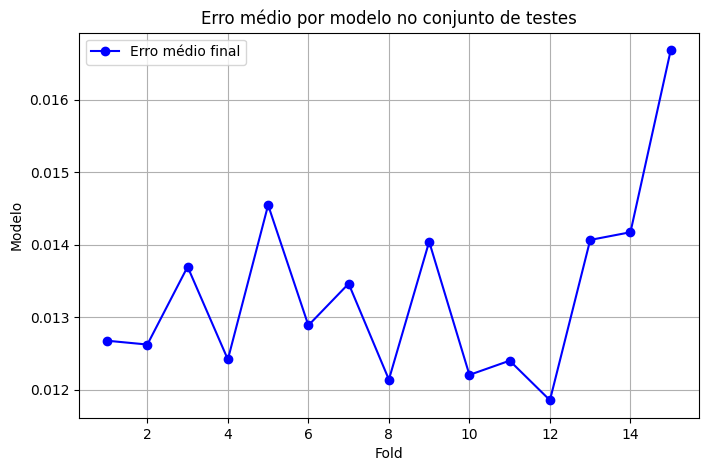

In [47]:
# Índices do vetor (0 a 6)
indices = list(range(1, len(acuracias) + 1))

# Criar o gráfico
plt.figure(figsize=(8, 5))
plt.plot(indices, erros_teste, marker='o', linestyle='-', color='b', label='Erro médio final')

# Adicionar títulos e legendas
plt.title('Erro médio por modelo no conjunto de testes')
plt.xlabel('Fold')
plt.ylabel('Modelo')
plt.legend()

# Mostrar o gráfico
plt.grid(True)
plt.show()